I. Get tickers and data of component companies in S&P500

1. Script list of component companies in S&P500 from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
2. Obtain the sector information of components and store in a data frame.
3. Get daily prices of components from Yahoo Finance and calculate their daily price changes.  

Reference:   
http://www.thealgoengineer.com/2014/download_sp500_data/  
http://stackoverflow.com/questions/28174193/add-new-column-based-on-a-list-and-sort-date-by-newest/28210920#28210920

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import requests_cache
requests_cache.install_cache('cache')

from bs4 import BeautifulSoup
from pandas import DataFrame
#from scipy.spatial.distance import pdist, squareform
from yahoo_finance import Share

In [2]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(response.content, 'html.parser')

# Get the names of components of S&P500
raw1 = soup.find_all(rel="nofollow")
tickers=[string.next_element for string in raw1]
for name in tickers:
    if len(name)>4:
        tickers.remove(name)
tickers = tickers[:505]
tickers = [str.replace('.', '-') for str in tickers] # tickers with . inside names cannot be searched in Yahoo finance

# Obtain the sectors which the components belong to
raw2 = soup.find_all('td')
raw3 = [raw2[3+8*i] for i in range(505)]
sectors = [string.next_element for string in raw3]

# Build the data frame of components information
sp500 = pd.DataFrame(data = zip(tickers,sectors), columns = ['tickers','sectors'])
sp500.to_csv('sp500.csv')
# There are 505 constituents of S&P 500 index.

# Set up a dictionary for components for further convenient
sp500_dic = {key:val for key, val in zip(tickers, sectors)}

In [3]:
# Function to retrieve the daily close price for a specific stock from Yahoo Finance
def get_stockprice(ticker, start_date, end_date):
    """
    Return the daily adjusted close price of one stock in a certain period.
    Args:
    ticker(string): stock symbol of a company.
    start_date, end_date(string): time interval bounds in the format of 'yyyy-mm-dd'.
    """
    stock = Share(ticker)
    df = pd.DataFrame(stock.get_historical(start_date, end_date))
    df.index = df['Date']
    df.rename(columns = {'Adj_Close':ticker}, inplace = True)
    df[ticker] = pd.to_numeric(df[ticker])
    return df[ticker]

In [4]:
# Get prices for 505 constituents in year 2016
df = pd.DataFrame()
for ticker in sp500['tickers']:
    df1 = get_stockprice(ticker, '2016-01-01', '2016-12-31')
    df = pd.concat([df, df1], axis=1)

In [5]:
df.to_csv('price_2016.csv')
df.head()

,MMM,ABT,ABBV,ACN,ATVI,AYI,ADBE,AAP,AES,AET,...,XEL,XRX,XLNX,XL,XYL,YHOO,YUM,ZBH,ZION,ZTS
2016-01-04,142.064009,41.607202,54.911736,99.812499,37.316330,232.559162,91.970001,152.008069,8.964187,108.059193,...,34.542465,6.568387,44.325527,37.119225,35.442166,31.400000,50.480539,100.939863,26.393169,46.784278
2016-01-05,142.683276,41.597508,54.682976,100.331997,36.840205,235.510893,92.339996,150.969645,9.087765,109.562484,...,34.890793,6.555633,44.983635,37.196944,35.432341,32.200001,50.354706,103.041747,26.106610,47.516672
2016-01-06,139.809484,41.248603,54.692509,100.135962,36.493031,229.298284,91.019997,146.975739,8.774065,109.008641,...,35.258469,6.472731,44.161002,36.876362,34.990295,32.160000,49.998176,103.487898,25.345743,47.526572
2016-01-07,136.403504,40.260032,54.530470,97.195400,35.977228,223.215302,89.110001,148.603260,8.555427,109.058087,...,35.393933,6.294173,42.418951,36.108913,34.086561,30.160000,48.292420,101.108416,24.584876,46.081575
2016-01-08,135.939057,39.416837,53.043537,96.254413,35.421747,214.878632,87.849998,145.338238,8.679006,105.893260,...,35.006901,6.115615,41.547924,35.409470,33.762393,30.629999,47.635285,100.682091,24.308199,45.408562


In [6]:
# Function to calculate the changes in price
def price_change(df):
    """
    Return the data frame of price change
    Arg:
    df(data frame): the daily price data for stocks
    """
    change = pd.DataFrame()
    for i in range(len(df)-1):
        diff = np.subtract(np.log(df.iloc[i,:]), np.log(df.iloc[i+1,:]))
        change = pd.concat([change, diff],axis=1)
    return change

In [7]:
# Get price changes
change = price_change(df).transpose()
change.to_csv('change_2016.csv')

II. Build minimum spanning tree  
1. Calculate the correlation matrix of price change
2. Obtain the edge list by Prim's algorithm of minimum spanning tree
3. Creat the Graph object by networkingx  

Schematising of Minimum Spanning Tree:
1. rank a couple of vertices(stocks) from the nearest to the farthest  
2. draw the first edge from this rank  
3. continue in the rank  
4. if the new edge does not close a cycle draw it  
5. go to point 3  
6. stop when all the vertices have been drawn  

Reference:  
https://mktstk.com/2015/03/04/stock-market-visualization-minimum-spanning-trees/  
http://peekaboo-vision.blogspot.com/2012/02/simplistic-minimum-spanning-tree-in.html  

In [8]:
# Calculate the correlation matrix of price changes 
corr = change.corr()
corr.to_csv('change_2016.csv')

# Calculate the distance between pairwise stocks
# distance[i, j] = sqrt(2.0 * ( 1 – correlation[i, j] ) )
dist = 1- abs(corr) # adjusted 
dist.to_csv('dist_2016.csv')

In [9]:
# Prim's algotithm to get edge list by minimum spanning trees
def minimum_spanning_tree(X, copy_X=True):
    """X are edge weights of fully connected graph"""
    if copy_X:
        X = X.copy()
 
    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    n_vertices = X.shape[0]
    spanning_edges = []
     
    # initialize with node 0:                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 1
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf
     
    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices                                                      
        new_edge = divmod(new_edge, n_vertices)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                       
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
    return np.vstack(spanning_edges)

In [10]:
# Get edges
dist = np.array(dist)
edge_list_raw = minimum_spanning_tree(dist)
edge_list = []
for i, j in edge_list_raw:
    edge = (tickers[i], tickers[j])
    edge_list.append(edge)

In [19]:
edges = pd.DataFrame(edge_list)
edges.to_csv('edges_2016.csv')

In [13]:
# Create graph object by adding edges
mst = nx.Graph()
for i, j in edge_list:
    mst.add_edge(i,j)

In [14]:
# Set up nodes positions
pos=nx.spring_layout(mst)

In [15]:
# Assign colors of nodes
colors_list = ['red', 'green', 'blue', 'grey', 'cyan', 'magenta', 'yellow', 'orange', 'darkviolet', 'pink', 'peru']
dic_col = {key:val for key, val in zip(set(sp500['sectors']), colors_list)}
color_map = []
for n in G.nodes():
    sec = sp500_dic[n]
    color_map.append(dic_col[sec])

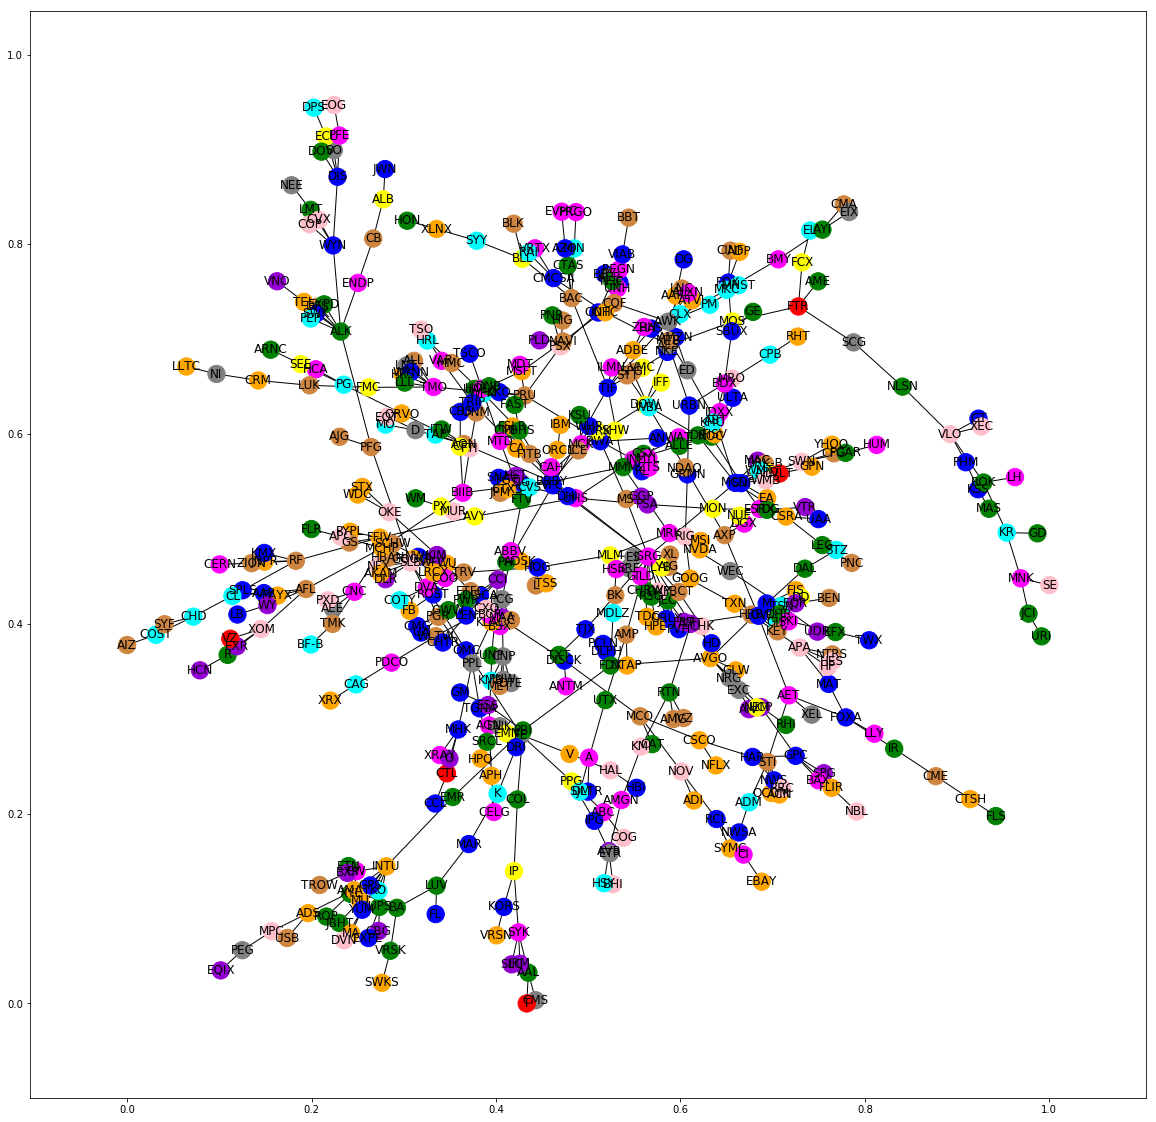

In [16]:
# Plot network    
plt.figure(figsize = (20,20))
nx.draw_networkx(mst, pos = pos, node_color = color_map)
plt.show()